# 3D Poisson Equation

In [1]:
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import ngsolve

In [2]:
geo = Box((0,0,0), (1,1,1))

geo.faces.name="outer"

DrawGeo(geo);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [3]:
from ngsolve import *
from ngsolve.webgui import Draw
mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=0.3)).Curve(3)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [4]:
mesh.GetBoundaries()

('outer', 'outer', 'outer', 'outer', 'outer', 'outer')

## Poisson problem (Strong form)

Steady state heat: $u : \Omega \rightarrow R$

Linear strain:
$$
-\Delta u + u = f
$$

Boundary conditions:
$$
u = u_D \qquad \text{on} \, \Gamma_D\\
\frac{\partial u}{\partial n} = g \qquad \text{on} \, \Gamma_N
$$

Data:
$$
f = 1 \\
u_D = 0\\
g = 2
$$
Variational formulation:
--- 
Find: $u \in H^1(\Omega)$ such that $u = u_D$ on $\Gamma_D$
$$
\int_\Omega \nabla u . \nabla v \, dx + \int_\Omega u v \, dx = \int_\Omega f v dx + \int_{\Gamma_N} g v ds
$$
holds for all $v = 0$ on $\Gamma_D$.

In [5]:
fes = H1(mesh, order=3)
u,v = fes.TnT()
gfu = GridFunction(fes)

with TaskManager():
    a = BilinearForm(grad(u)*grad(v)*dx+u*v*dx)
#     pre = Preconditioner(a, "bddc")
    a.Assemble()

In [6]:
force = 1
g = x
f = LinearForm(force*v*dx + g*v*ds("outer")).Assemble()

In [7]:
gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec

In [8]:
# from ngsolve.krylovspace import CGSolver
# inv = CGSolver(a.mat, pre, printrates='\r', tol=1e-8)
# gfu.vec.data = inv * f.vec

In [9]:
Draw (gfu, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [10]:
print(gfu.vec)

 3.73712
 3.73677
 3.73708
 3.73651
 4.75472
  4.7551
 4.75471
 4.75533
 3.70962
 3.70975
 3.70962
  3.7095
 3.70994
 3.70971
 3.70988
 3.70991
 4.56399
 4.56377
   4.564
 4.56404
 4.56373
 4.56381
 4.56369
 4.56367
 3.93871
 4.33483
 3.93861
 4.33498
 3.93853
 4.33505
 3.93855
 4.33511
  3.6816
  3.6898
 3.68959
 3.68393
 3.68099
 3.67208
 4.36919
 4.40136
 4.40201
 4.37959
 4.36687
 4.33242
 3.86265
 3.80846
 4.22828
   4.355
 4.04661
 3.86258
 3.80837
 4.22834
 4.35505
 4.04661
  3.8626
  3.8084
 4.22828
 4.35507
 4.04658
 3.86259
 3.80842
 4.22827
   4.355
  4.0466
 3.80573
 3.74297
 3.76669
 3.74355
 4.12178
 4.19069
 4.18766
 4.12779
 4.01787
 4.24151
 3.93106
  3.9323
 4.12684
 -0.00768553
 0.0188592
 -0.00794063
 0.0160539
 0.308677
 -0.04943
 -0.0263979
 0.0343419
 0.119972
 -0.0128073
 0.0450222
 0.0194057
 -0.0100604
 0.0256759
 -0.0089725
 0.026242
 0.307578
 -0.0590731
 -0.00876978
 0.0205756
 -0.00918799
 0.0217135
 0.308489
 -0.0561921
 -0.0221402
 0.0352309
 0.119546
 -

In [17]:
mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=0.0625)).Curve(3)
fes = H1(mesh, order=2)
u,v = fes.TnT()
exact_gfu = GridFunction(fes)

with TaskManager():
    a = BilinearForm(grad(u)*grad(v)*dx + u*v*dx)
    a.Assemble()
    force = 1
    g = x
    f = LinearForm(force*v*dx + g*v*ds("outer")).Assemble()
    exact_gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec

In [18]:
Draw(exact_gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [19]:
# from ngsolve.krylovspace import CGSolver

In [26]:
mesh_size = [0.5, 0.25, 0.125,  0.0625, 0.03125] #, 0.015625]
dofs = []
errors = []

for h in mesh_size:
    mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=h)).Curve(3)
    fes = H1(mesh, order=1)
    u,v = fes.TnT()
    gfu = GridFunction(fes)

    with TaskManager():
        a = BilinearForm(grad(u)*grad(v)*dx + u*v*dx)
#         pre = Preconditioner(a, "bddc")
        a.Assemble()
        force = 1
        g = x
        f = LinearForm(force*v*dx + g*v*ds("outer")).Assemble()
        gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
#         inv = CGSolver(a.mat, pre, printrates='\r', tol=1e-8)
#         gfu.vec.data = inv * f.vec
        dofs.append(fes.ndof)
        
    err = sqrt (Integrate ( (gfu-exact_gfu)*(gfu-exact_gfu), mesh))
    errors.append(err)


In [27]:
errors

[0.03237782729474175,
 0.007454305253025955,
 0.0016647719003890133,
 0.0004531523960319344,
 0.00011365297264529204]

In [4]:
import numpy as np
for i in range(len(mesh_size)-1):
    print("Convergence rate:", np.log(errors[i+1]/errors[i])/np.log(mesh_size[i+1]/mesh_size[i]))


NameError: name 'mesh_size' is not defined

In [2]:
dofs = [21, 138, 920, 5786, 42316]

In [7]:
adofs = [4.0, 16.0, 64.0, 256.0, 1024.0]
adofs = [1/h**2 for h in mesh_size]
print(adofs)

NameError: name 'mesh_size' is not defined

In [1]:
errors = [0.03237782729474175,
 0.007454305253025955,
 0.0016647719003890133,
 0.0004531523960319344,
 0.00011365297264529204]

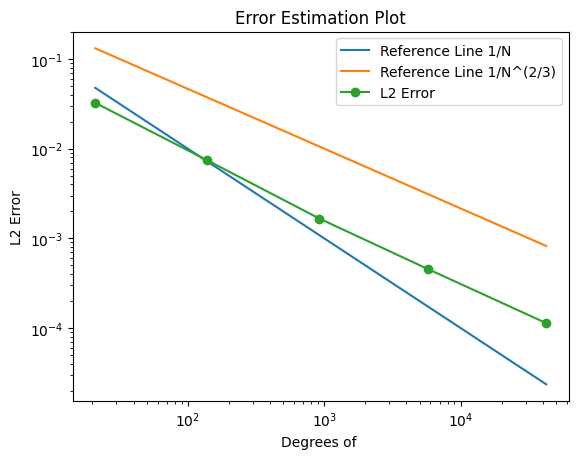

In [13]:
import matplotlib.pyplot as plt
plt.loglog(dofs, np.divide(np.ones(len(dofs)), np.array(dofs)), label="Reference Line 1/N")
plt.loglog(dofs, np.divide(np.ones(len(dofs)), np.square(np.cbrt(np.array(dofs)))), label="Reference Line 1/N^(2/3)")
plt.loglog(dofs,errors, "-o", label="L2 Error")
plt.title("Error Estimation Plot")
plt.xlabel("Degrees of ")
plt.ylabel("L2 Error")
plt.legend()
plt.show()